In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import pylab as plt
from pyem import star, mrc
import os
from shutil import copyfile
from glob import glob
import string
from liquid_tem import regroup_pics, clean_autopick

In [5]:
meta = pd.read_pickle('meta.pkl')

In [6]:
# load result of first 2DCA
lbl = 'Class2D/2DCASgl_G2/run_it050'

writefigs = True
fig_format = 'png'

model = star.parse_multi_star(lbl + '_model.star', keep_index = False)
particles = star.parse_star(lbl +'_data.star', keep_index = False)
particles['shotNr'] = particles.index
caimgs = mrc.read(lbl + '_classes.mrcs')

# extract classes table
classes = model['data_model_classes'].copy()
classes.index = classes['rlnReferenceImage'].str.extract('(\d+)@',expand=False).astype(int)
classes.index.name = 'rlnClassNumber'

# extract groups table
groups = model['data_model_groups'].copy()
groups.index = groups['rlnGroupNumber']

# settings for plots
psz = (16,15) # figure size
pcols = 7 # number of columns
pgrid = (int(np.ceil(len(classes)/float(pcols))),pcols)

# make figure directory
if writefigs: 
    figdir = lbl + '/figures'
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    figdir = figdir + '/'

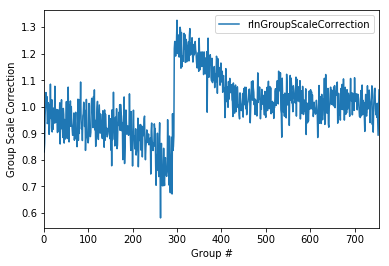

In [5]:
# show Group Scale Correction: basic FOM for groups
groups.plot(y='rlnGroupScaleCorrection')
plt.ylabel('Group Scale Correction')
plt.xlabel('Group #')
if writefigs:
    plt.savefig(figdir + 'group_scale_correction', format = fig_format)

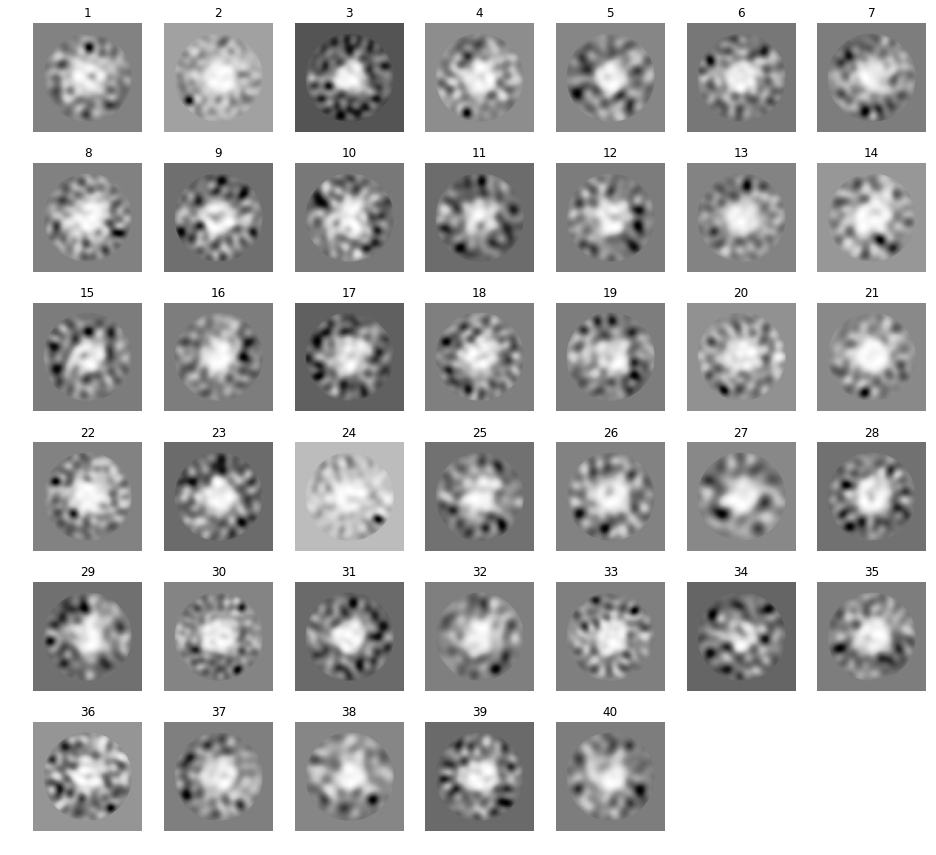

In [6]:
# show class images
plt.figure(figsize=psz)
scale = -1
for k in range(len(classes)):
    plt.subplot(pgrid[0],pgrid[1],k+1)
    plt.imshow(scale*caimgs[:,:,k].T,aspect='equal',cmap='Greys')
    plt.axis('off')
    plt.title(classes.index[k])    
    #plt.clim(vmin=-1, vmax=1)
if writefigs:
    plt.savefig(figdir + '2DCA', format = fig_format)

In [7]:
# statistics for each class...
clgr = particles.groupby('rlnClassNumber', sort=True)

# get shot distribution metrics
classes['shotMedian'] = [np.median(x) for _,x in clgr.indices.iteritems()]
classes['shotMean'] = [np.mean(x) for _,x in clgr.indices.iteritems()]
classes['shotStd'] = [np.std(x) for _,x in clgr.indices.iteritems()]

# get SSNR for all classes
ssnr = [(idx, model['data_model_class_{}'.format(idx)]['rlnSsnrMap']) for idx,_ in classes.iterrows()]
ssnr = pd.DataFrame.from_items(ssnr)
ssnr.index = model['data_model_class_{}'.format(classes.index[0])]['rlnResolution']

# get shot distribution histograms
shotDist = [(idx, np.histogram(itm['shotNr'], bins=100, range=(0,len(particles)))[0]) for idx, itm in clgr]
shotDist = pd.DataFrame.from_items(shotDist)
shotDist.index = np.linspace(0,len(particles),num=100,endpoint=False)

# get in-plane angle distribution histograms
psiDist = [(idx, np.histogram(itm['rlnAnglePsi'], bins=30, range=(-180,180))[0]) for idx, itm in clgr]
psiDist = pd.DataFrame.from_items(psiDist)
psiDist.index = np.linspace(-180,180,num=30,endpoint=False)

classes['nShots'] = clgr['shotNr'].agg('count')

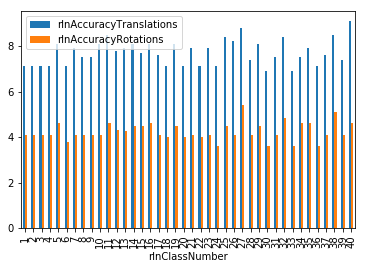

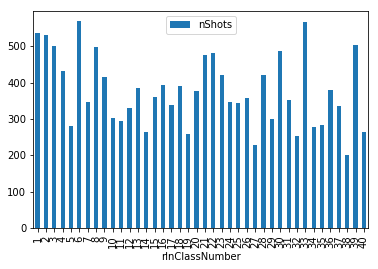

In [8]:
# bar plots of scalar class properties
classes.plot.bar(y=['rlnAccuracyTranslations','rlnAccuracyRotations'])
classes.plot.bar(y=['nShots'])
if writefigs:
    plt.savefig(figdir + 'class_stats', format = fig_format)

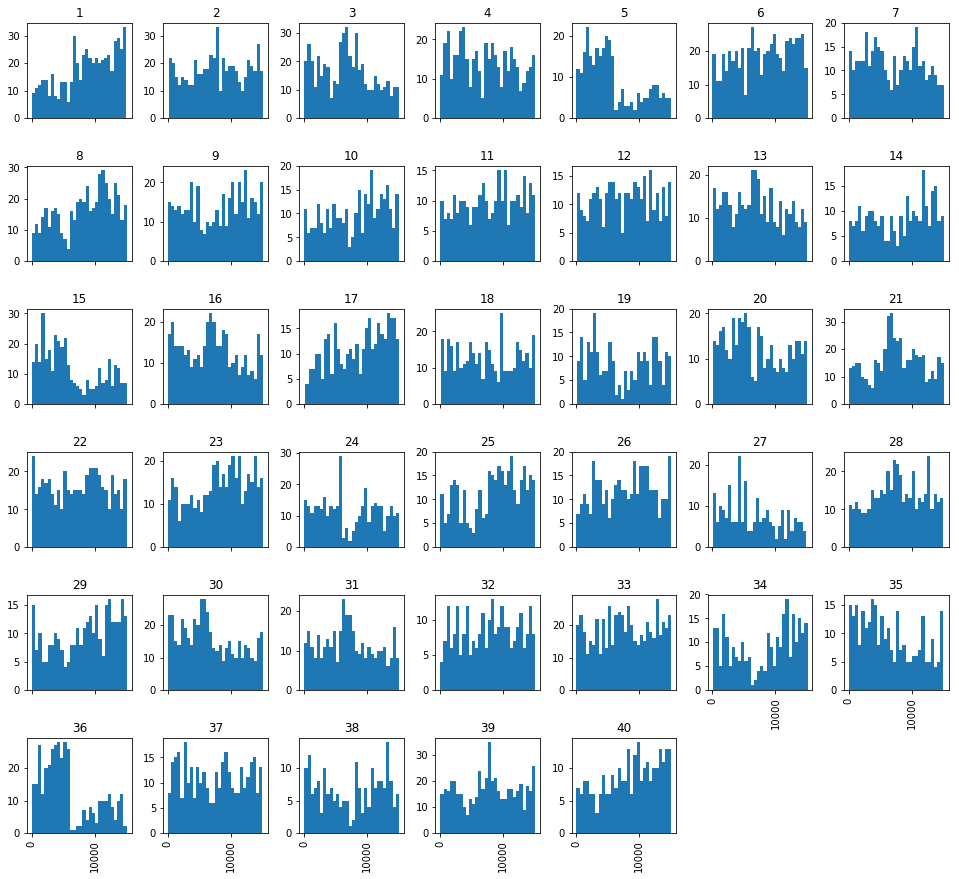

In [9]:
# Grouped histogram plot of shot Numbers
particles.hist(column='shotNr',by='rlnClassNumber',sharex=True,layout=pgrid,figsize=psz,bins=30);
if writefigs:
    plt.savefig(figdir + 'particle_hist', format = fig_format)

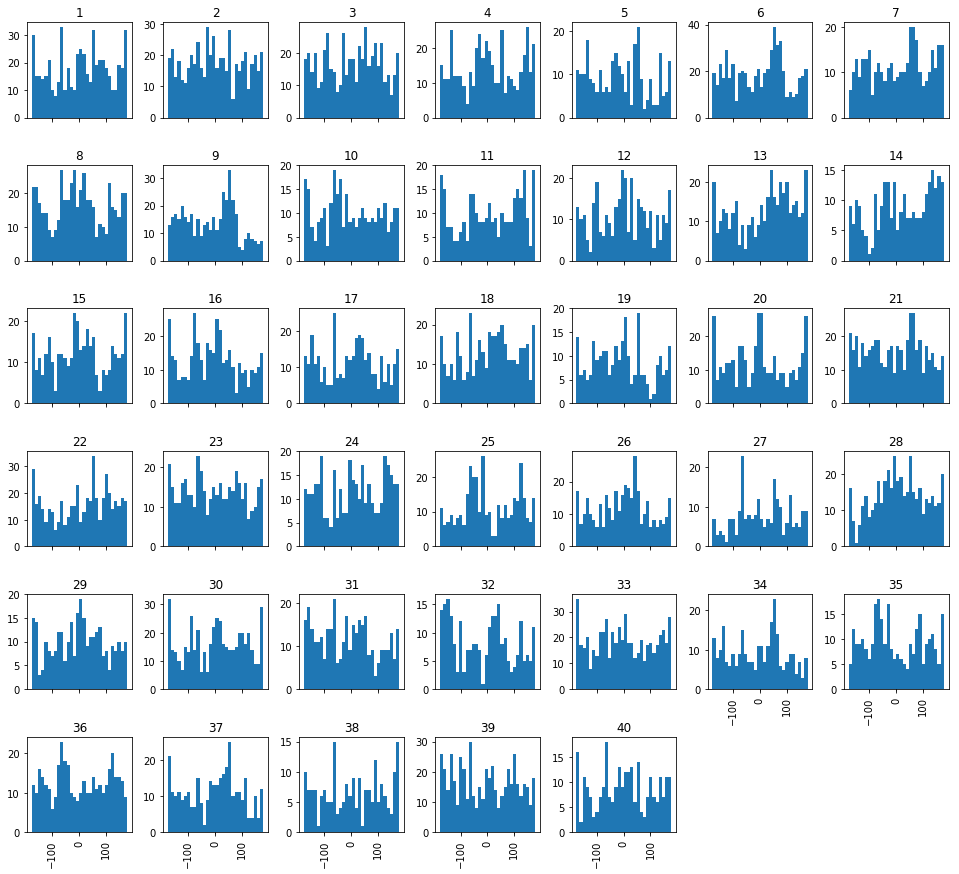

In [10]:
# Grouped histogram plots of in-plane rotation
particles.hist(column='rlnAnglePsi',by='rlnClassNumber',sharex=True,layout=pgrid,figsize=psz,bins=30);
if writefigs:
    plt.savefig(figdir + 'angle_hist', format = fig_format)

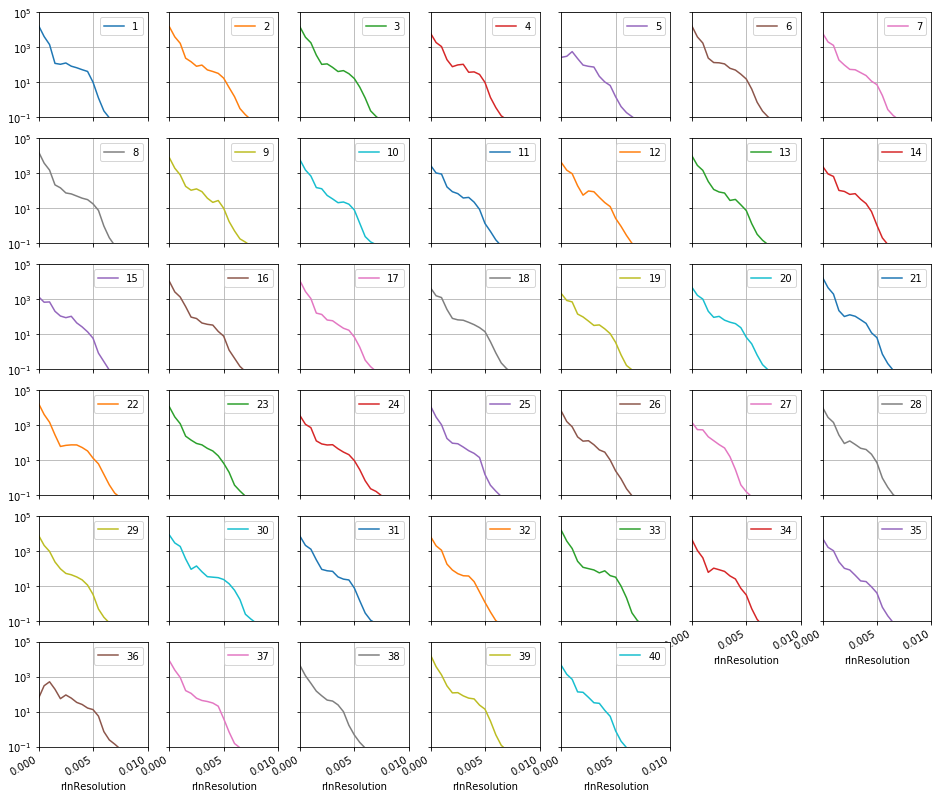

In [11]:
# show sSNR of all classes
ssnr.plot(logy=True,subplots=True,sharex=True,sharey=True,
          figsize=psz,layout=pgrid,grid=True,
          xlim=(0,0.01),ylim=(0.1,1e5));
if writefigs:
    plt.savefig(figdir + 'ssnr', format = fig_format)

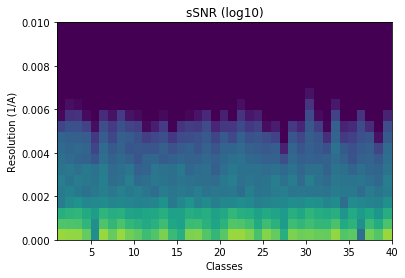

In [12]:
# show sSNR as false color
plt.figure()
plt.pcolor(ssnr.columns, ssnr.index, np.log10(ssnr + 1e-30))
plt.clim([0, 5])
plt.ylim(0,0.01)
plt.xlabel('Classes')
plt.ylabel('Resolution (1/A)')
plt.title('sSNR (log10)')
if writefigs:
    plt.savefig(figdir + 'ssnr_pcolor', format = fig_format)

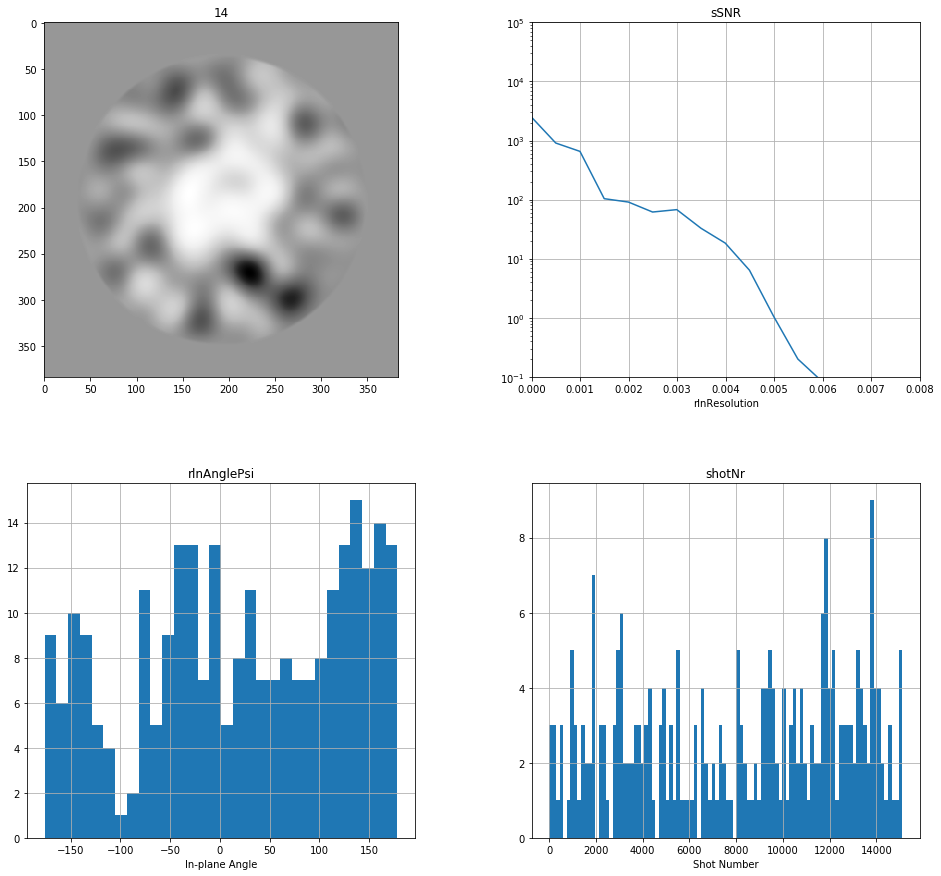

In [13]:
# get overview plot for a given class
idx = 14

scale = -1
plt.figure(figsize=psz)
cl = classes.loc[idx,:]
img = caimgs[:,:,int(cl['rlnReferenceImage'].split('@')[0])-1].T
plt.subplot(2,2,1)
plt.imshow(scale*img,cmap='Greys',aspect='equal')
plt.title(idx)
plt.subplot(2,2,2)
ssnr.loc[:,idx].plot(logy=True,ylim=(0.1,1e5),xlim=(0,0.008),grid = True)
plt.title('sSNR')
ax = plt.subplot(2,2,3)
clgr.get_group(idx).hist(column='rlnAnglePsi', bins = 30, ax = ax)
plt.xlabel('In-plane Angle')
ax = plt.subplot(2,2,4)
clgr.get_group(idx).hist(column='shotNr', bins = 100, ax = ax, range=(0,len(particles)))
plt.xlabel('Shot Number')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


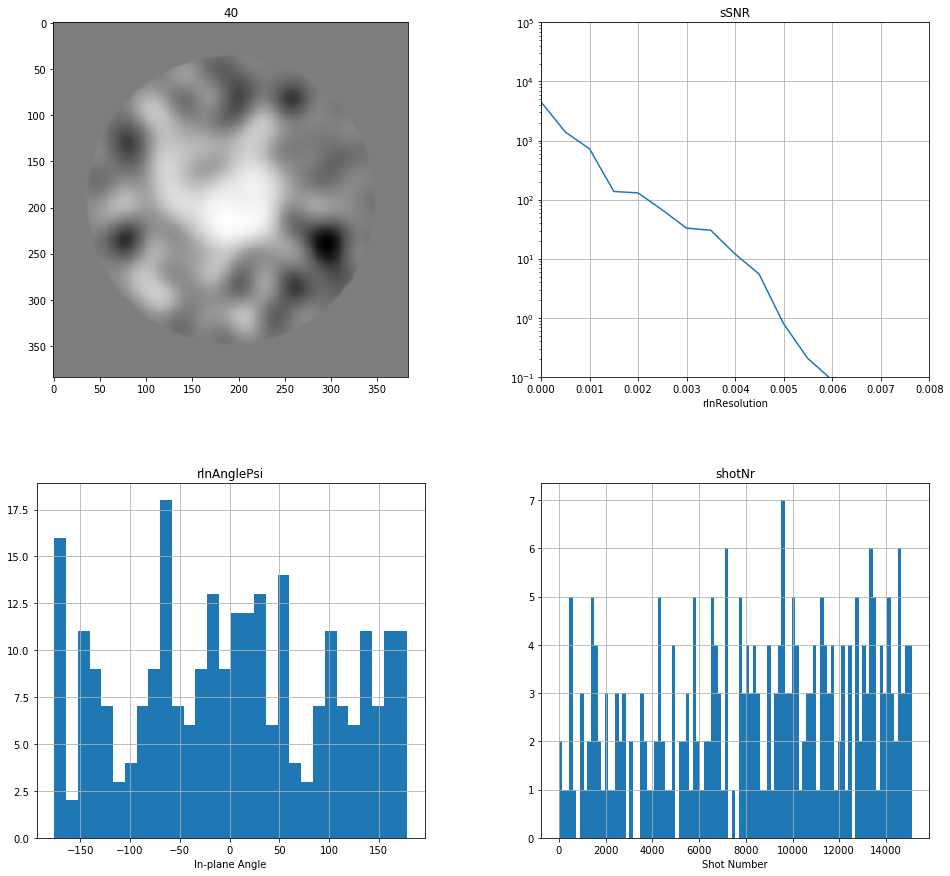

In [14]:
# export overview plots for ALL classes
scale = -1
plt.figure(figsize=psz)

if writefigs:
    for idx, cl in classes.iterrows():
        print(idx)
        plt.clf()
        img = caimgs[:,:,int(cl['rlnReferenceImage'].split('@')[0])-1].T
        plt.subplot(2,2,1)
        plt.imshow(scale*img,cmap='Greys',aspect='equal')
        plt.title(idx)
        plt.subplot(2,2,2)
        ssnr.loc[:,idx].plot(logy=True,ylim=(0.1,1e5),xlim=(0,0.008),grid = True)
        plt.title('sSNR')
        ax = plt.subplot(2,2,3)
        clgr.get_group(idx).hist(column='rlnAnglePsi', bins = 30, ax = ax)
        plt.xlabel('In-plane Angle')
        ax = plt.subplot(2,2,4)
        clgr.get_group(idx).hist(column='shotNr', bins = 100, ax = ax, range=(0,len(particles)))
        plt.xlabel('Shot Number')
        plt.savefig(figdir + 'class_{:03d}'.format(idx), format = fig_format)